In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [80]:
# 1. Load and sort data
df = pd.read_csv("cocoa_data.csv")
df["YearMonth"] = pd.to_datetime(df["YearMonth"])
df = df.sort_values("YearMonth").reset_index(drop=True)

# 2. Split first (data leakage-safe)
cutoff = pd.to_datetime("2023-12-01")
train_df = df[df["YearMonth"] <= cutoff].copy()
test_df = df[df["YearMonth"] > cutoff].copy()

train_df["Monthly_log_Price"] = np.log(train_df["Monthly_Price"])

# 3. STL decomposition on training data only
stl = STL(train_df["Monthly_log_Price"], period=12)
res = stl.fit()
train_df["trend"] = res.trend
train_df["seasonal"] = res.seasonal
train_df["resid"] = res.resid

# 4. Fit models on decomposed components
trend_train = train_df["trend"]
seasonal_train = train_df["seasonal"]
resid_train = train_df["resid"]


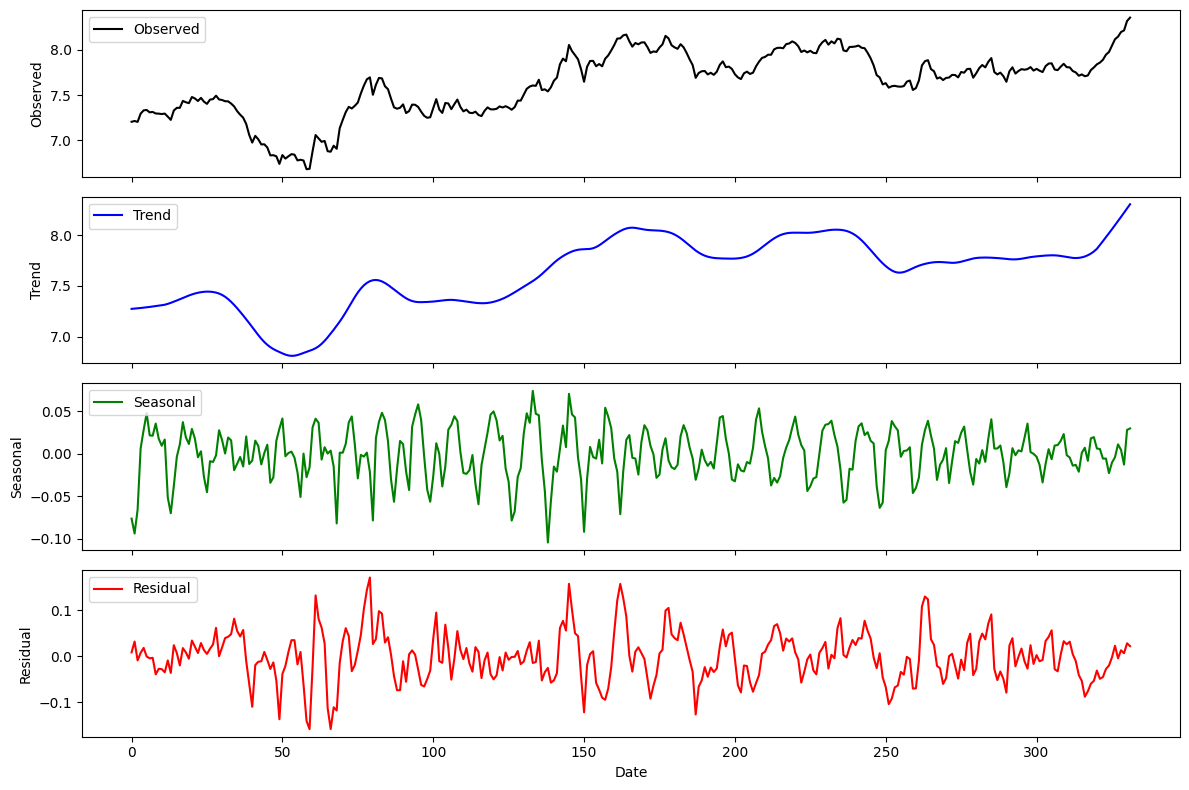

In [82]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(train_df.index, train_df["Monthly_log_Price"], label="Observed", color="black")
axs[0].set_ylabel("Observed")
axs[0].legend(loc="upper left")

axs[1].plot(train_df.index, train_df["trend"], label="Trend", color="blue")
axs[1].set_ylabel("Trend")
axs[1].legend(loc="upper left")

axs[2].plot(train_df.index, train_df["seasonal"], label="Seasonal", color="green")
axs[2].set_ylabel("Seasonal")
axs[2].legend(loc="upper left")

axs[3].plot(train_df.index, train_df["resid"], label="Residual", color="red")
axs[3].set_ylabel("Residual")
axs[3].legend(loc="upper left")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [83]:
def plot_acf_pacf(series, lags=40, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    plot_pacf(series.dropna(), lags=lags, ax=axes[1])
    axes[0].set_title(f"{title_prefix} - ACF")
    axes[1].set_title(f"{title_prefix} - PACF")
    plt.tight_layout()
    plt.show()

def plot_multiple_acf_pacf(series_list, labels, lags=40):
    n = len(series_list)
    fig, axes = plt.subplots(n, 2, figsize=(14, 4 * n))

    for i, (series, label) in enumerate(zip(series_list, labels)):
        plot_acf(series.dropna(), lags=lags, ax=axes[i, 0])
        axes[i, 0].set_title(f"{label} - ACF")

        plot_pacf(series.dropna(), lags=lags, ax=axes[i, 1])
        axes[i, 1].set_title(f"{label} - PACF")

    plt.tight_layout()
    plt.show()

## Basic SARIMA

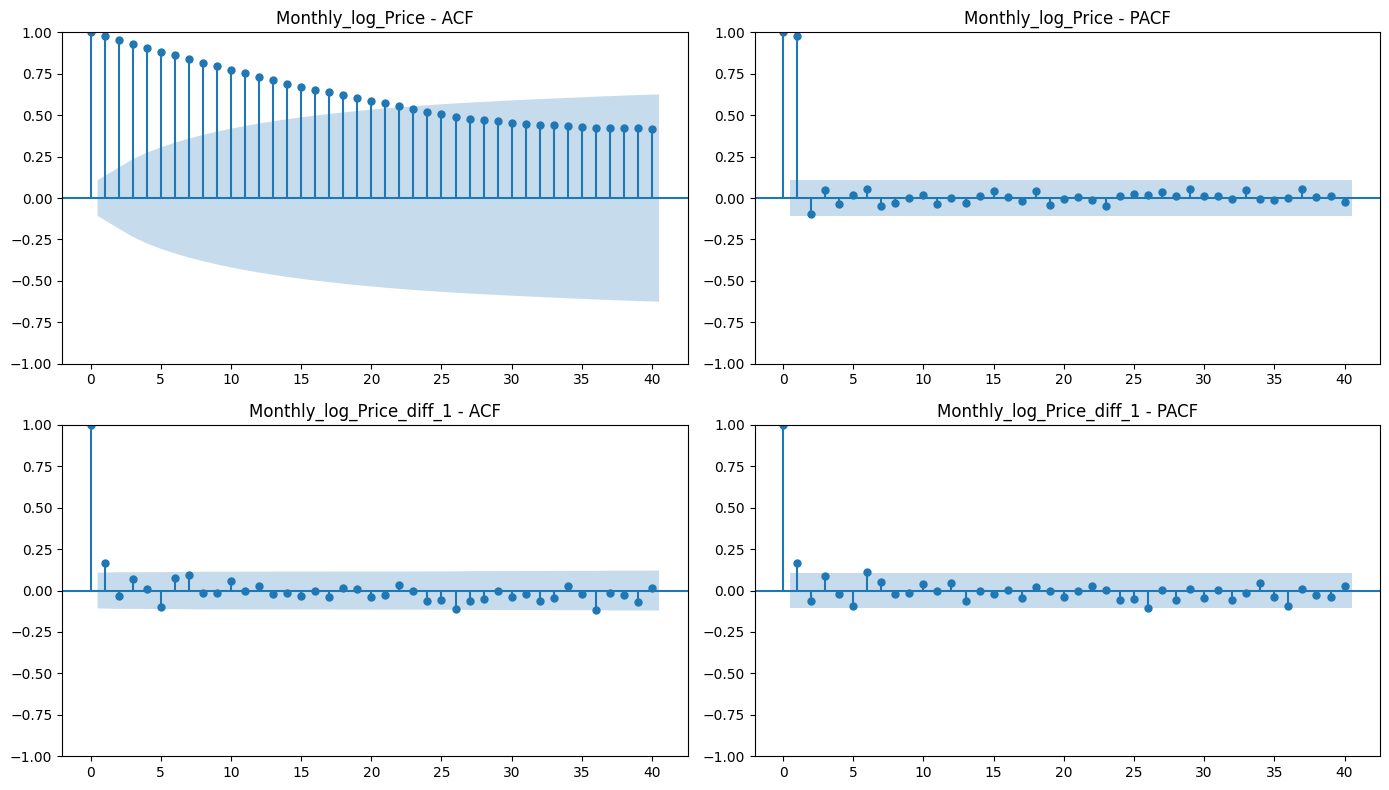

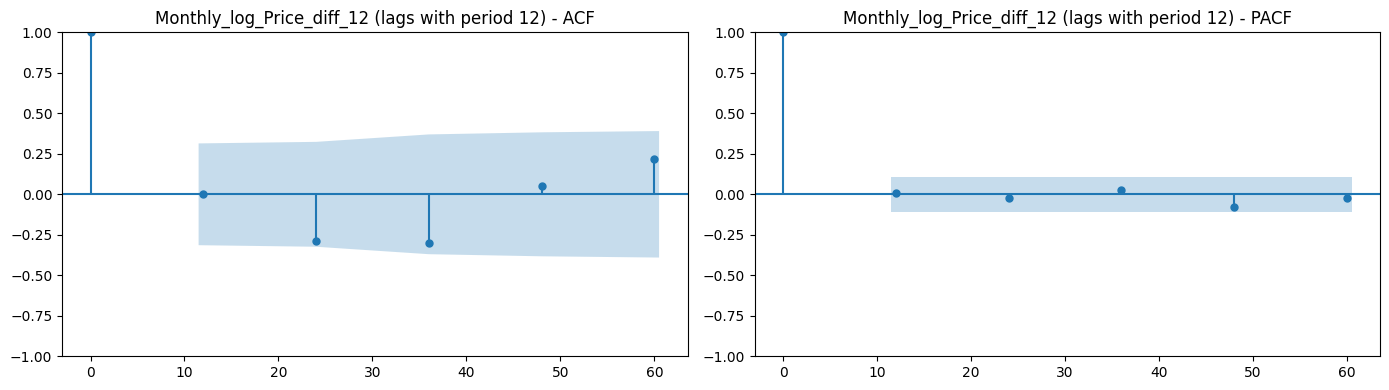

In [84]:
# plot_acf_pacf(train_df["Monthly_log_Price"], title_prefix="Montly_log_Price")  # find non-statioonary
# plot_acf_pacf(train_df["Monthly_log_Price"].diff(), title_prefix="Montly_log_Price_diff_1")  # find stationary
plot_multiple_acf_pacf(
    series_list=[
        train_df["Monthly_log_Price"],
        train_df["Monthly_log_Price"].diff()
    ],
    labels=["Monthly_log_Price", "Monthly_log_Price_diff_1"]
)


seasonal_lags = [12 * i for i in range(0, 6)]
# plot_multiple_acf_pacf(
#     series_list=[
#         train_df["Monthly_log_Price"],
#         train_df["Monthly_log_Price"].diff()
#     ],
#     labels=["Seasonal_Monthly_log_Price (period 12)", "Seasonal_Monthly_log_Price_diff_1 (period 12)"],
#     lags=seasonal_lags
# )

plot_acf_pacf(train_df["Monthly_log_Price"].diff(12), title_prefix="Monthly_log_Price_diff_12 (lags with period 12)", 
              lags=seasonal_lags)  # find stationary

# suggest SARIMA (1, 1, 1) (1, 1, 1, 12)

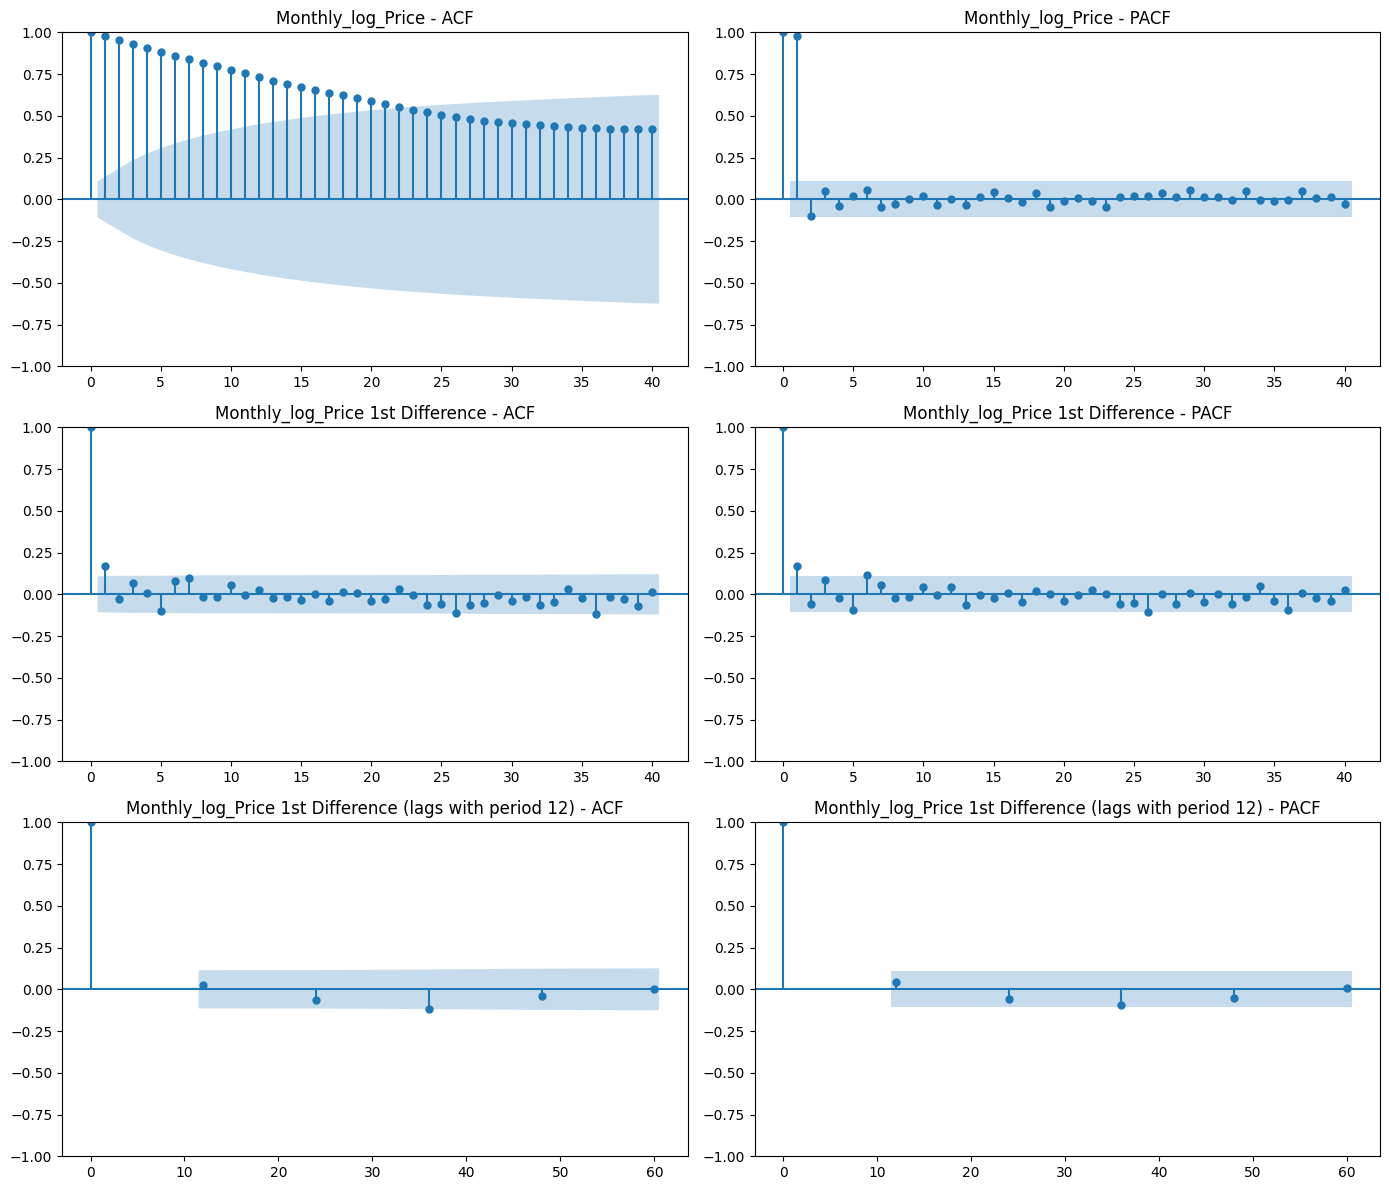

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Row 1: Original series
plot_acf(train_df["Monthly_log_Price"].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title("Monthly_log_Price - ACF")
plot_pacf(train_df["Monthly_log_Price"].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title("Monthly_log_Price - PACF")

# Row 2: First difference
plot_acf(train_df["Monthly_log_Price"].diff().dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title("Monthly_log_Price 1st Difference - ACF")
plot_pacf(train_df["Monthly_log_Price"].diff().dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title("Monthly_log_Price 1st Difference - PACF")

seasonal_lags = [12 * i for i in range(0, 6)]
# Row 3: Seasonal difference
plot_acf(train_df["Monthly_log_Price"].diff().dropna(), lags=seasonal_lags, ax=axes[2, 0])
axes[2, 0].set_title("Monthly_log_Price 1st Difference (lags with period 12) - ACF")
plot_pacf(train_df["Monthly_log_Price"].diff().dropna(), lags=seasonal_lags, ax=axes[2, 1])
axes[2, 1].set_title("Monthly_log_Price 1st Difference (lags with period 12) - PACF")

# Layout adjustment
plt.tight_layout()
plt.show()

In [88]:
def plot_main_diagnostics(model_results, model_name="SARIMA"):
    fig = model_results.plot_diagnostics(figsize=(14, 10))
    fig.suptitle(f"{model_name} - Residual Diagnostics", fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_ljung_box(model_results, model_name="SARIMA"):
    standardized_resid = model_results.filter_results.standardized_forecasts_error[0]
    standardized_resid = standardized_resid[~np.isnan(standardized_resid)]
    ljung_box = acorr_ljungbox(standardized_resid, lags=20, return_df=True)

    plt.figure(figsize=(12, 3))  # wide and short
    plt.scatter(ljung_box.index, ljung_box['lb_pvalue'], facecolors='none', edgecolors='black', s=40)
    plt.axhline(y=0.05, color='blue', linestyle='--', linewidth=1, label='0.05 threshold')
    plt.title(f"{model_name} - Ljung-Box Test p-values", fontsize=12)
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_clean_combined_diagnostics(model_results, model_name="SARIMA", lags=12):
    # Generate diagnostics plot
    diag_fig = model_results.plot_diagnostics(figsize=(16, 11))
    canvas = diag_fig.canvas
    canvas.draw()
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    img = img.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(diag_fig)

    # Automatically crop white margins from img
    gray = np.mean(img, axis=2)
    mask = gray < 243  # adjust if needed
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    cropped_img = img[y0:y1, x0:x1]

    # New combined figure
    fig = plt.figure(figsize=(14, 14))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)

    # Top: cropped diagnostics image
    ax_top = fig.add_subplot(gs[0])
    ax_top.axis('off')
    ax_top.imshow(cropped_img)

    # Bottom: Ljung-Box plot
    standardized_resid = model_results.filter_results.standardized_forecasts_error[0]
    standardized_resid = standardized_resid[~np.isnan(standardized_resid)]
    ljung_box = acorr_ljungbox(standardized_resid, lags=lags, return_df=True)

    ax_bottom = fig.add_subplot(gs[1])
    ax_bottom.scatter(ljung_box.index, ljung_box['lb_pvalue'], facecolors='none', edgecolors='black', s=40)
    ax_bottom.axhline(y=0.05, color='blue', linestyle='--', linewidth=1, label='0.05 threshold')
    ax_bottom.set_title("Ljung-Box Test p-values", fontsize=13)
    ax_bottom.set_xlabel("Lag")
    ax_bottom.set_ylabel("p-value")
    ax_bottom.set_ylim(0, 1)
    ax_bottom.grid(True, linestyle='--', alpha=0.5)
    ax_bottom.legend(fontsize=9)
    fig.suptitle(f"{model_name} - diagnostics", fontsize=12)
    plt.tight_layout()
    plt.show()



C:\Users\Dennis\AppData\Local\Temp\ipykernel_29112\3971803122.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


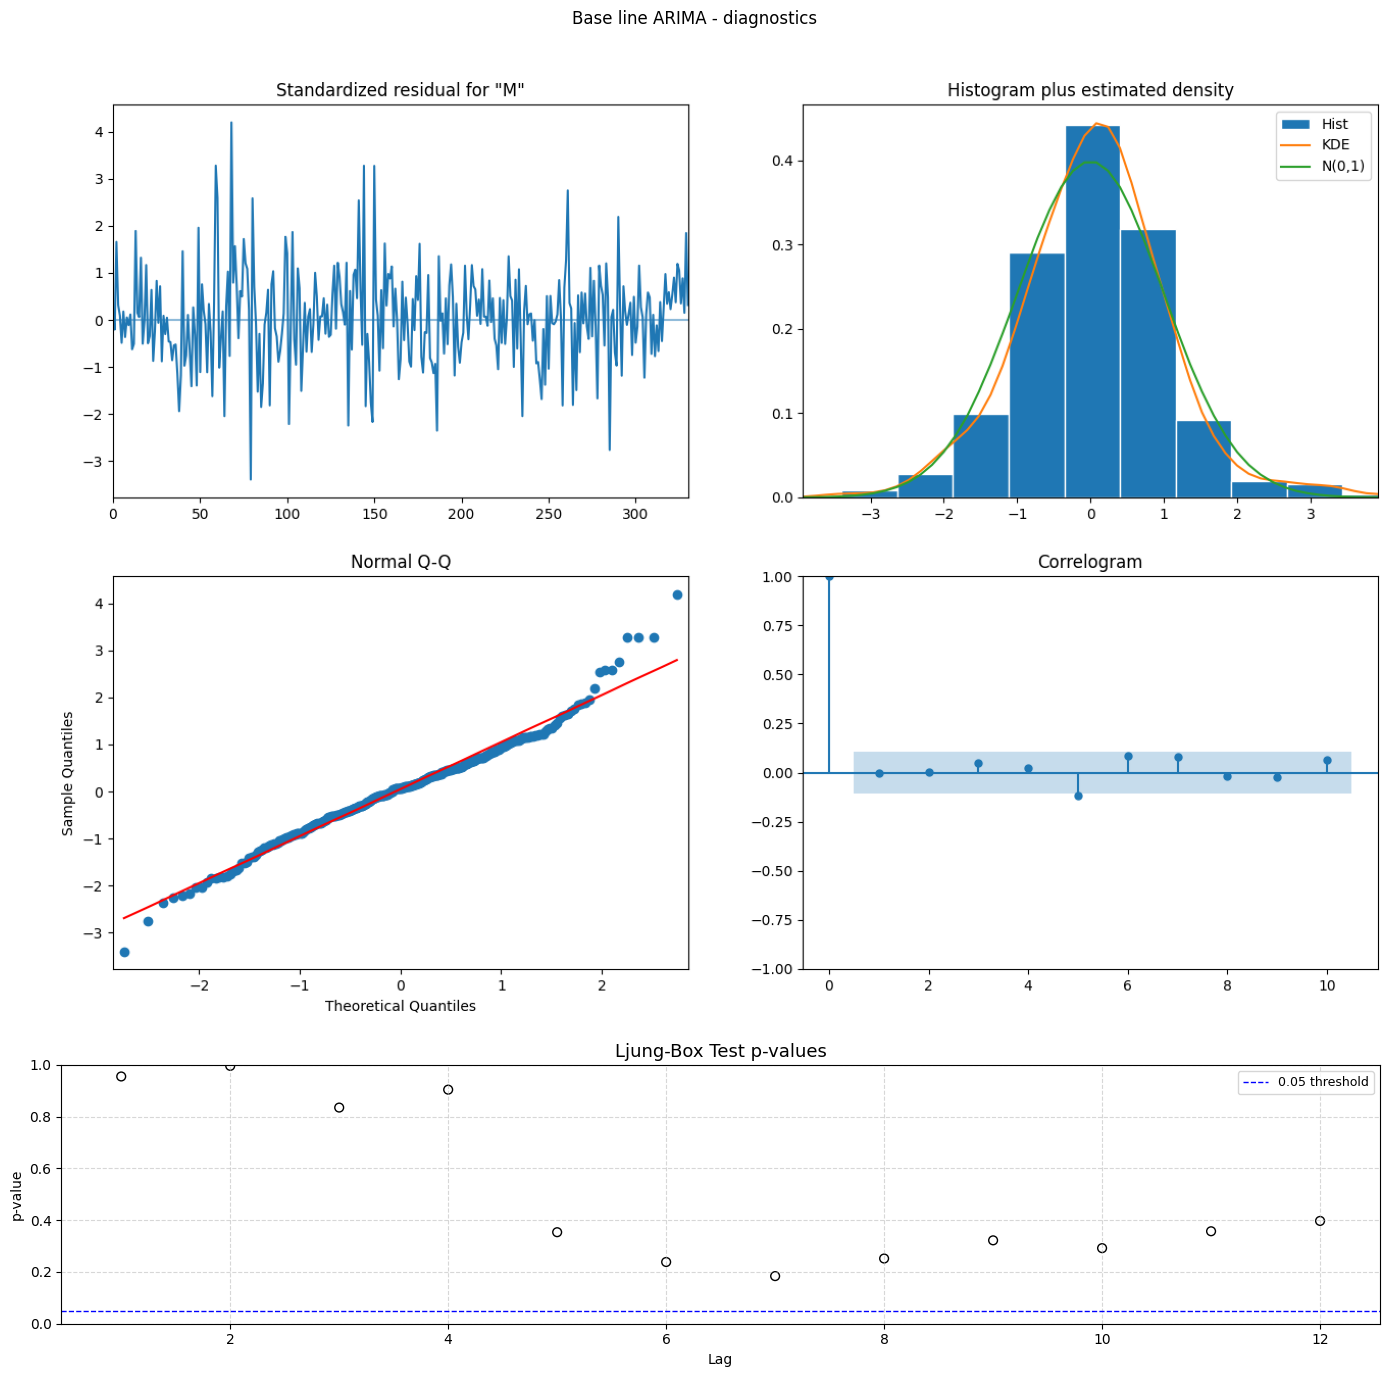

In [89]:
plot_clean_combined_diagnostics(base_sarima_results, "Base line ARIMA")



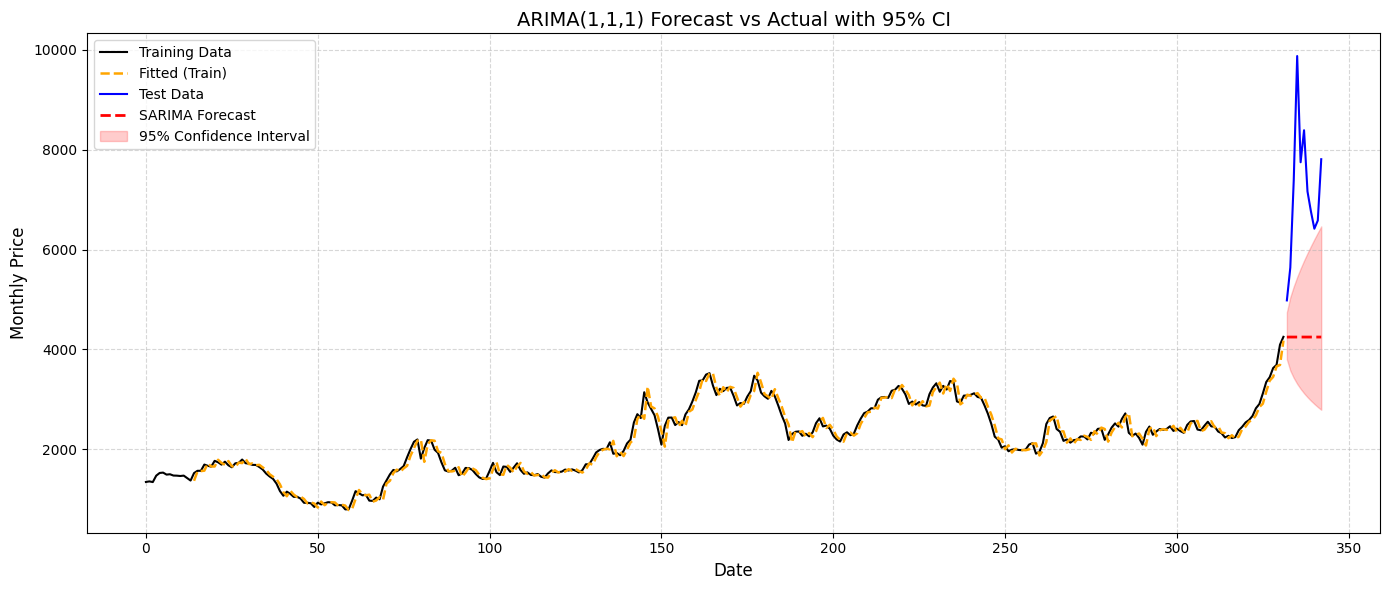

In [127]:
h = len(test_df)

burn_in = 14
fitted = base_sarima_results.get_prediction(start=burn_in)
fitted_log = fitted.predicted_mean
base_sarima_fitted_price = np.exp(fitted_log)

base_sarima_forecast = base_sarima_results.get_forecast(steps=h)
base_sarima_forecast_mean = np.exp(base_sarima_forecast.predicted_mean)
base_sarima_forecast_ci = np.exp(base_sarima_forecast.conf_int(alpha=0.05))

base_sarima_forecast_mean.index = test_df.index
base_sarima_forecast_ci.index = test_df.index

# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(train_df["Monthly_Price"], label="Training Data", color="black", linewidth=1.5)
plt.plot(base_sarima_fitted_price, label="Fitted (Train)", color="orange", linestyle="--", linewidth=1.8)
plt.plot(test_df["Monthly_Price"], label="Test Data", color="blue", linewidth=1.5)
plt.plot(base_sarima_forecast_mean, label="SARIMA Forecast", color="red", linestyle="--", linewidth=2)

# Confidence interval shading
plt.fill_between(base_sarima_forecast_ci.index,
                 base_sarima_forecast_ci.iloc[:, 0],
                 base_sarima_forecast_ci.iloc[:, 1],
                 color="red", alpha=0.2, label="95% Confidence Interval")

# Labels and formatting
plt.title("ARIMA(1,1,1) Forecast vs Actual with 95% CI", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Monthly Price", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

In [91]:

def evaluate_fitted(y_true, y_fitted, ci_df=None, model_name="Model (Train)"):
    rmse = np.sqrt(mean_squared_error(y_true, y_fitted))
    mae = mean_absolute_error(y_true, y_fitted)
    mape = mean_absolute_percentage_error(y_true, y_fitted)
    r2 = r2_score(y_true, y_fitted)

    print(f"\n🧪 Training Fit Metrics for {model_name}:")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.2%}")

    results = {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }

    if ci_df is not None:
        ci_lower = ci_df.iloc[:, 0]
        ci_upper = ci_df.iloc[:, 1]
        coverage = np.mean((y_true >= ci_lower) & (y_true <= ci_upper))
        print(f"95% CI Coverage (Train): {coverage:.2%}")
        results["Coverage"] = coverage

    return None


def evaluate_forecast(y_true, y_pred, ci_df=None, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"\n📊 Forecast Performance Metrics for {model_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.2%}")

    results = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }

    if ci_df is not None:
        ci_lower = ci_df.iloc[:, 0]
        ci_upper = ci_df.iloc[:, 1]
        coverage = np.mean((y_true >= ci_lower) & (y_true <= ci_upper))
        print(f"95% Prediction Interval Coverage: {coverage:.2%}")
        results["Coverage"] = coverage

    return None


In [92]:
evaluate_fitted(y_true = np.exp(train_df["Monthly_log_Price"].iloc[burn_in:])
, y_fitted=base_sarima_fitted_price, model_name="Base SARIMA (Train)")

evaluate_forecast(
    y_true=test_df["Monthly_Price"],
    y_pred=base_sarima_forecast_mean,
    ci_df=base_sarima_forecast_ci,
    model_name="Base SARIMA"
)



🧪 Training Fit Metrics for Base SARIMA (Train):
R²   : 0.9681
RMSE: 124.2860
MAE : 92.3266
MAPE: 4.31%

📊 Forecast Performance Metrics for Base SARIMA:
RMSE: 3177.2319
MAE : 2911.5251
MAPE: 38.74%
95% Prediction Interval Coverage: 0.00%


================================================================================================
## STL + ARIMA

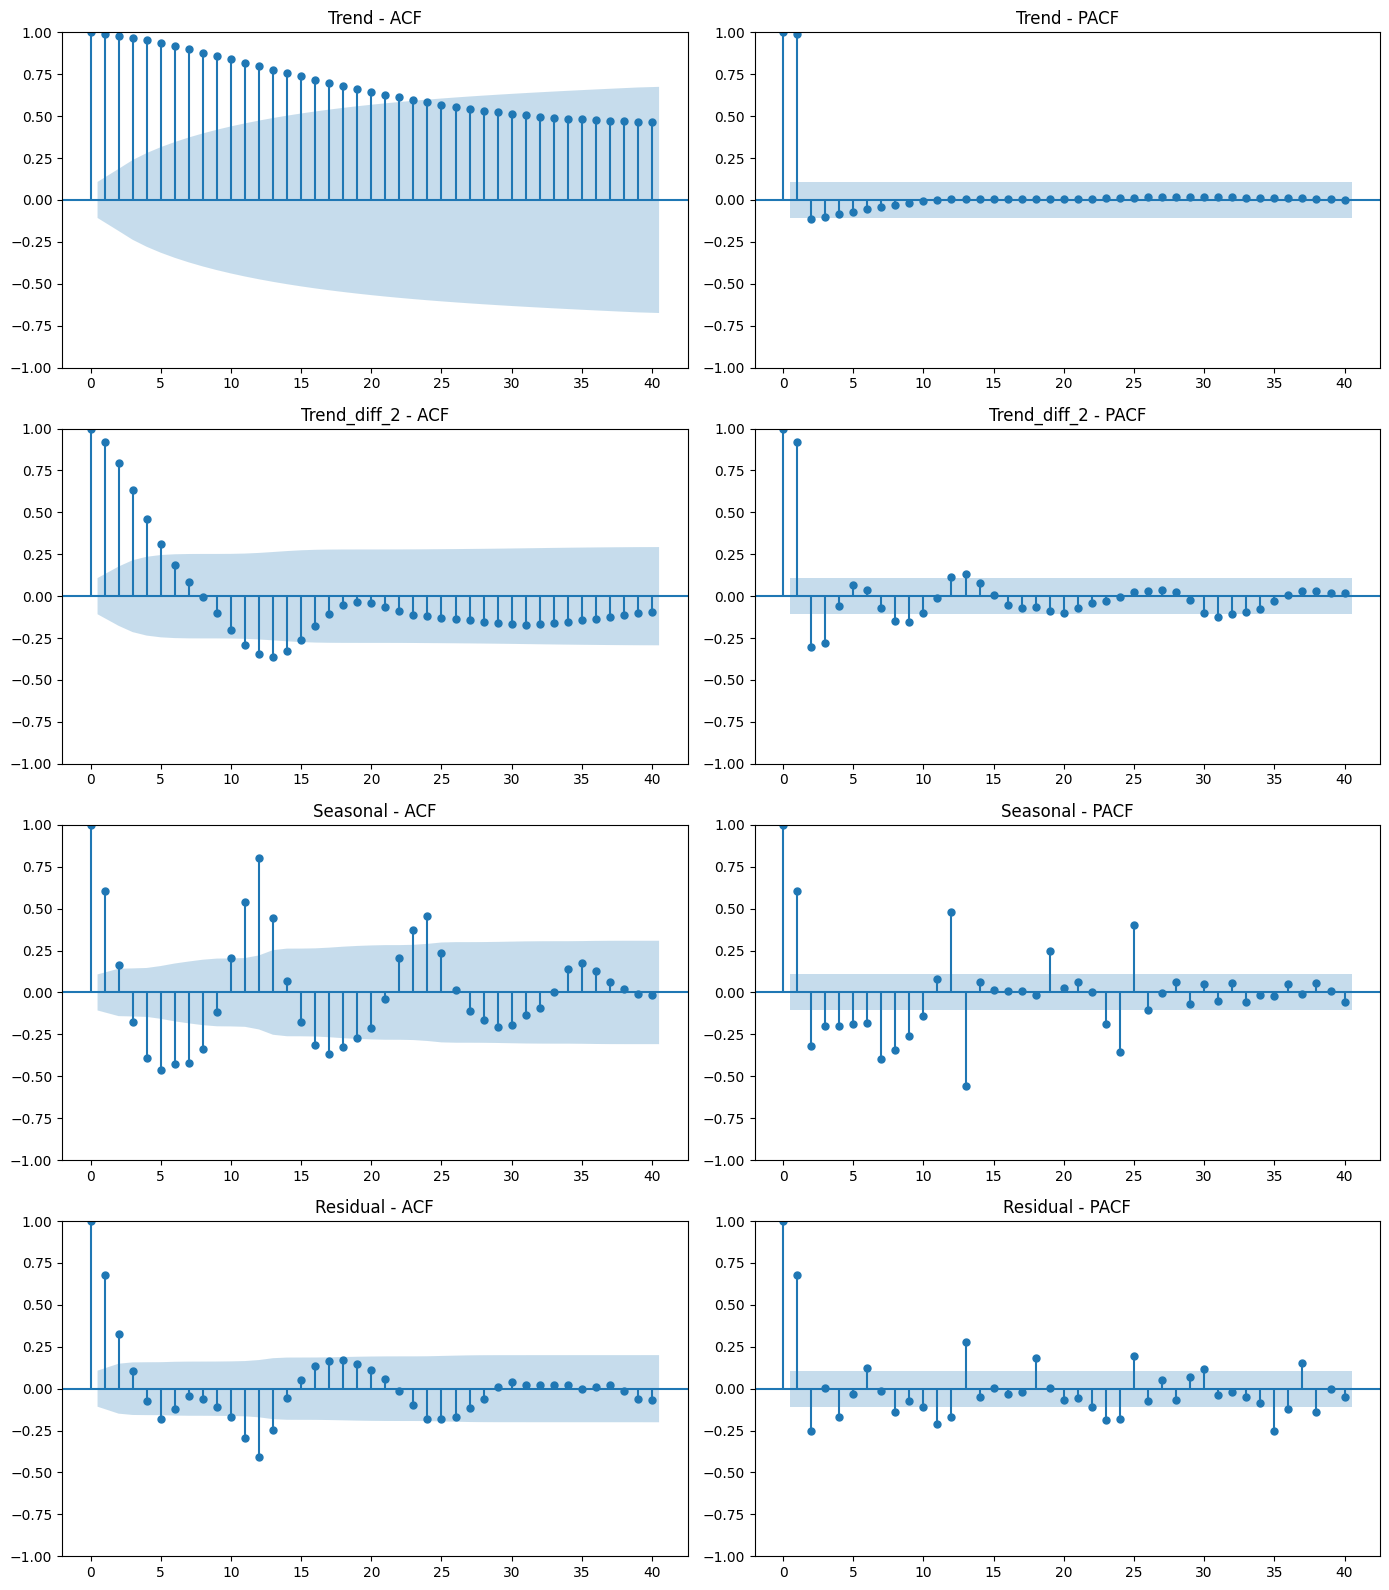

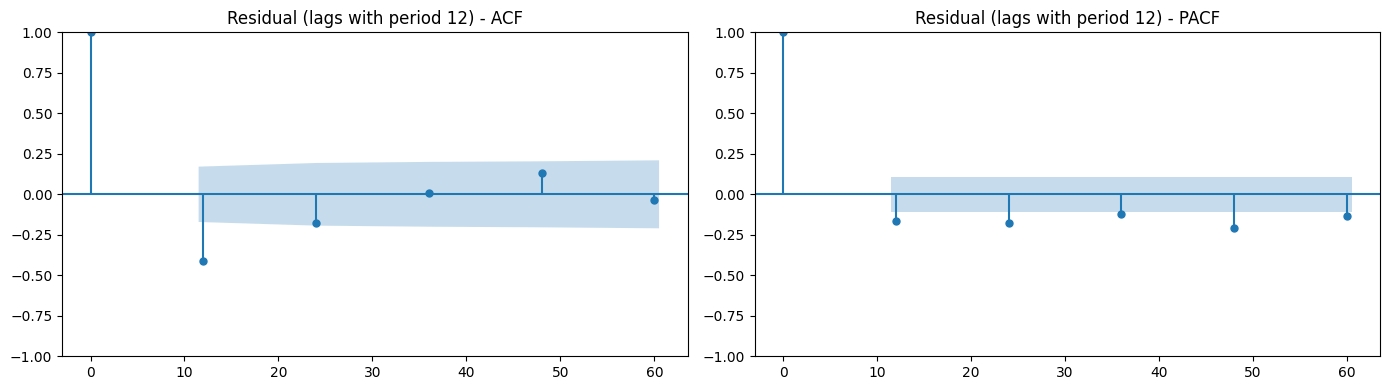

In [93]:
# plot_acf_pacf(trend_train.diff().diff(), title_prefix="Trend")
# plot_acf_pacf(seasonal_train, title_prefix="Seasonal")
# plot_acf_pacf(resid_train, title_prefix="Residual")

plot_multiple_acf_pacf(
    series_list=[
        trend_train,
        trend_train.diff().diff(),
        seasonal_train,
        resid_train
    ],
    labels=["Trend", "Trend_diff_2", "Seasonal", "Residual"]
)

seasonal_lags = [12 * i for i in range(0, 6)]
# plot_multiple_acf_pacf(
#     series_list=[
#         resid_train.diff(12)
#     ],
#     labels=["Residual_diff_12 (period 12 lags)"],
#     lags=seasonal_lags
# )

plot_acf_pacf(resid_train, title_prefix="Residual (lags with period 12)", lags=seasonal_lags)


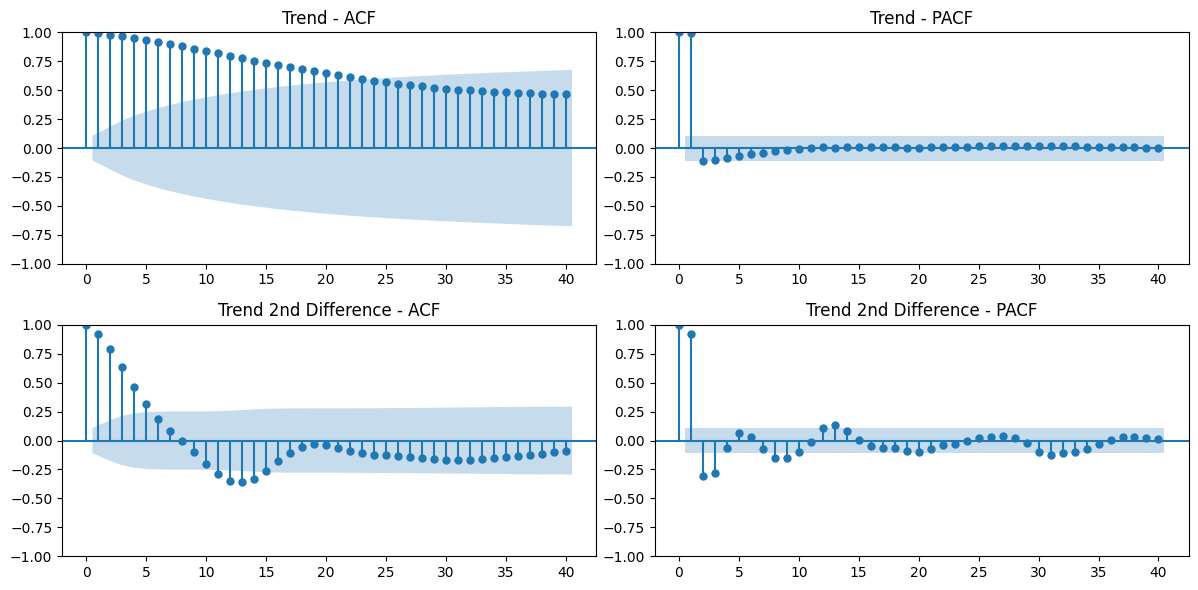

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Row 1: Original series
plot_acf(trend_train.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title("Trend - ACF")
plot_pacf(trend_train.dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title("Trend - PACF")

# Row 2: First difference
plot_acf(trend_train.diff().diff().dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title("Trend 2nd Difference - ACF")
plot_pacf(trend_train.diff().diff().dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title("Trend 2nd Difference - PACF")

# Layout adjustment
plt.tight_layout()
plt.show()

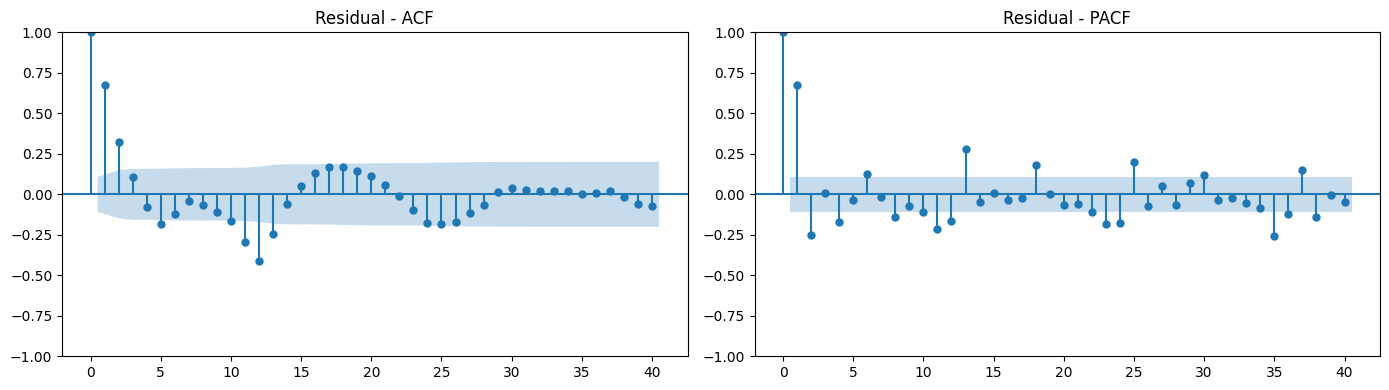

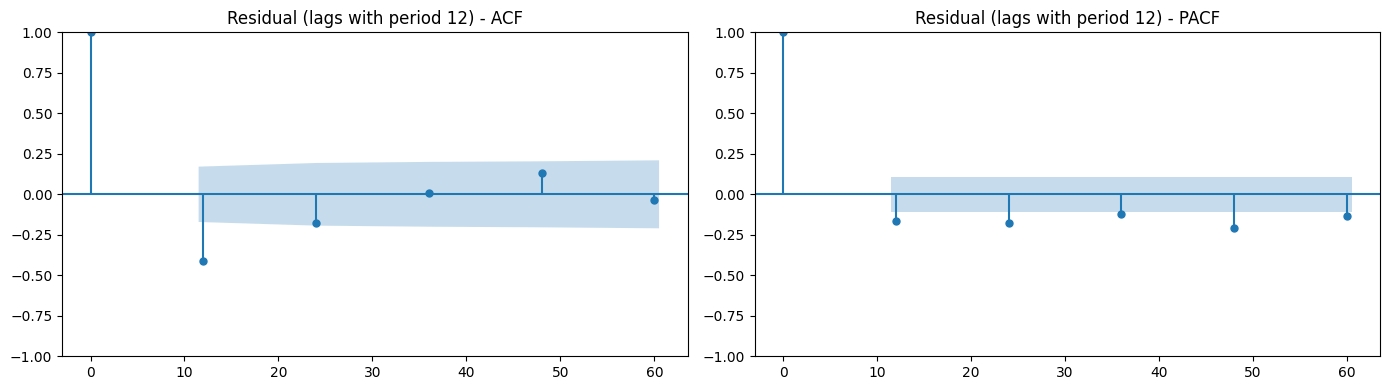

In [146]:
plot_acf_pacf(resid_train, title_prefix="Residual")
seasonal_lags = [12 * i for i in range(0, 6)]
plot_acf_pacf(resid_train, title_prefix="Residual (lags with period 12)", lags=seasonal_lags)


In [94]:
trend_auto = auto_arima(trend_train, seasonal=True, m=12)
seasonal_auto = auto_arima(seasonal_train, seasonal=True, m=12)
resid_auto = auto_arima(resid_train, seasonal=True, m=12)


In [96]:
seasonal_auto

ARIMA(order=(5, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [98]:
# trend_model = ARIMA(trend_train, order=(5, 2, 1)).fit() pass
trend_model = ARIMA(trend_train, order=(1, 2, 5)).fit()
seasonal_model = SARIMAX(seasonal_train, order=(5, 0, 2), seasonal_order=(2, 0, 2, 12)).fit()
# seasonal_model = ARIMA(seasonal_train, order=(1, 2, 5)).fit()
# resid_model = ARIMA(resid_train, order=(4, 1, 4)).fit()
resid_model = SARIMAX(resid_train, order=(2, 0, 2), seasonal_order=(1, 0, 1, 12)).fit()

trend_pred = trend_model.get_prediction(start=burn_in)
seasonal_pred = seasonal_model.get_prediction(start=burn_in)
resid_pred = resid_model.get_prediction(start=burn_in)

trend_fitted_log = trend_pred.predicted_mean
seasonal_fitted_log = seasonal_pred.predicted_mean
resid_fitted_log = resid_pred.predicted_mean

fitted_log_combined = trend_fitted_log + seasonal_fitted_log + resid_fitted_log
fitted_price = np.exp(fitted_log_combined)

fitted_price.index = train_df.index[burn_in:burn_in + len(fitted_price)]

actual_price_train = train_df["Monthly_Price"].iloc[burn_in:burn_in + len(fitted_price)]


# 5. Forecast horizon
h = len(test_df)

# 6. Forecast each component using their models
trend_forecast_result = trend_model.get_forecast(steps=h)
seasonal_forecast_result = seasonal_model.get_forecast(steps=h)
resid_forecast_result = resid_model.get_forecast(steps=h)

trend_forecast = trend_forecast_result.predicted_mean
seasonal_forecast = seasonal_forecast_result.predicted_mean
resid_forecast = resid_forecast_result.predicted_mean

# Get 95% confidence intervals
trend_ci = trend_forecast_result.conf_int(alpha=0.05)
seasonal_ci = seasonal_forecast_result.conf_int(alpha=0.05)
resid_ci = resid_forecast_result.conf_int(alpha=0.05)

# Combine lower and upper bounds
log_forecast_lower = trend_ci.iloc[:, 0] + seasonal_ci.iloc[:, 0] + resid_ci.iloc[:, 0]
log_forecast_upper = trend_ci.iloc[:, 1] + seasonal_ci.iloc[:, 1] + resid_ci.iloc[:, 1]

# Exponentiate to get final CI in original scale
forecast_price = np.exp(trend_forecast + seasonal_forecast + resid_forecast)
forecast_lower = np.exp(log_forecast_lower)
forecast_upper = np.exp(log_forecast_upper)

# Store in test_df for plotting
test_df["forecast"] = forecast_price.values
test_df["forecast_lower"] = forecast_lower.values
test_df["forecast_upper"] = forecast_upper.values
test_df["trend_forecast"] = trend_forecast.values
test_df["seasonal_forecast"] = seasonal_forecast.values
test_df["resid_forecast"] = resid_forecast.values


c:\Users\Dennis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dennis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Dennis\AppData\Local\Temp\ipykernel_29112\3971803122.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


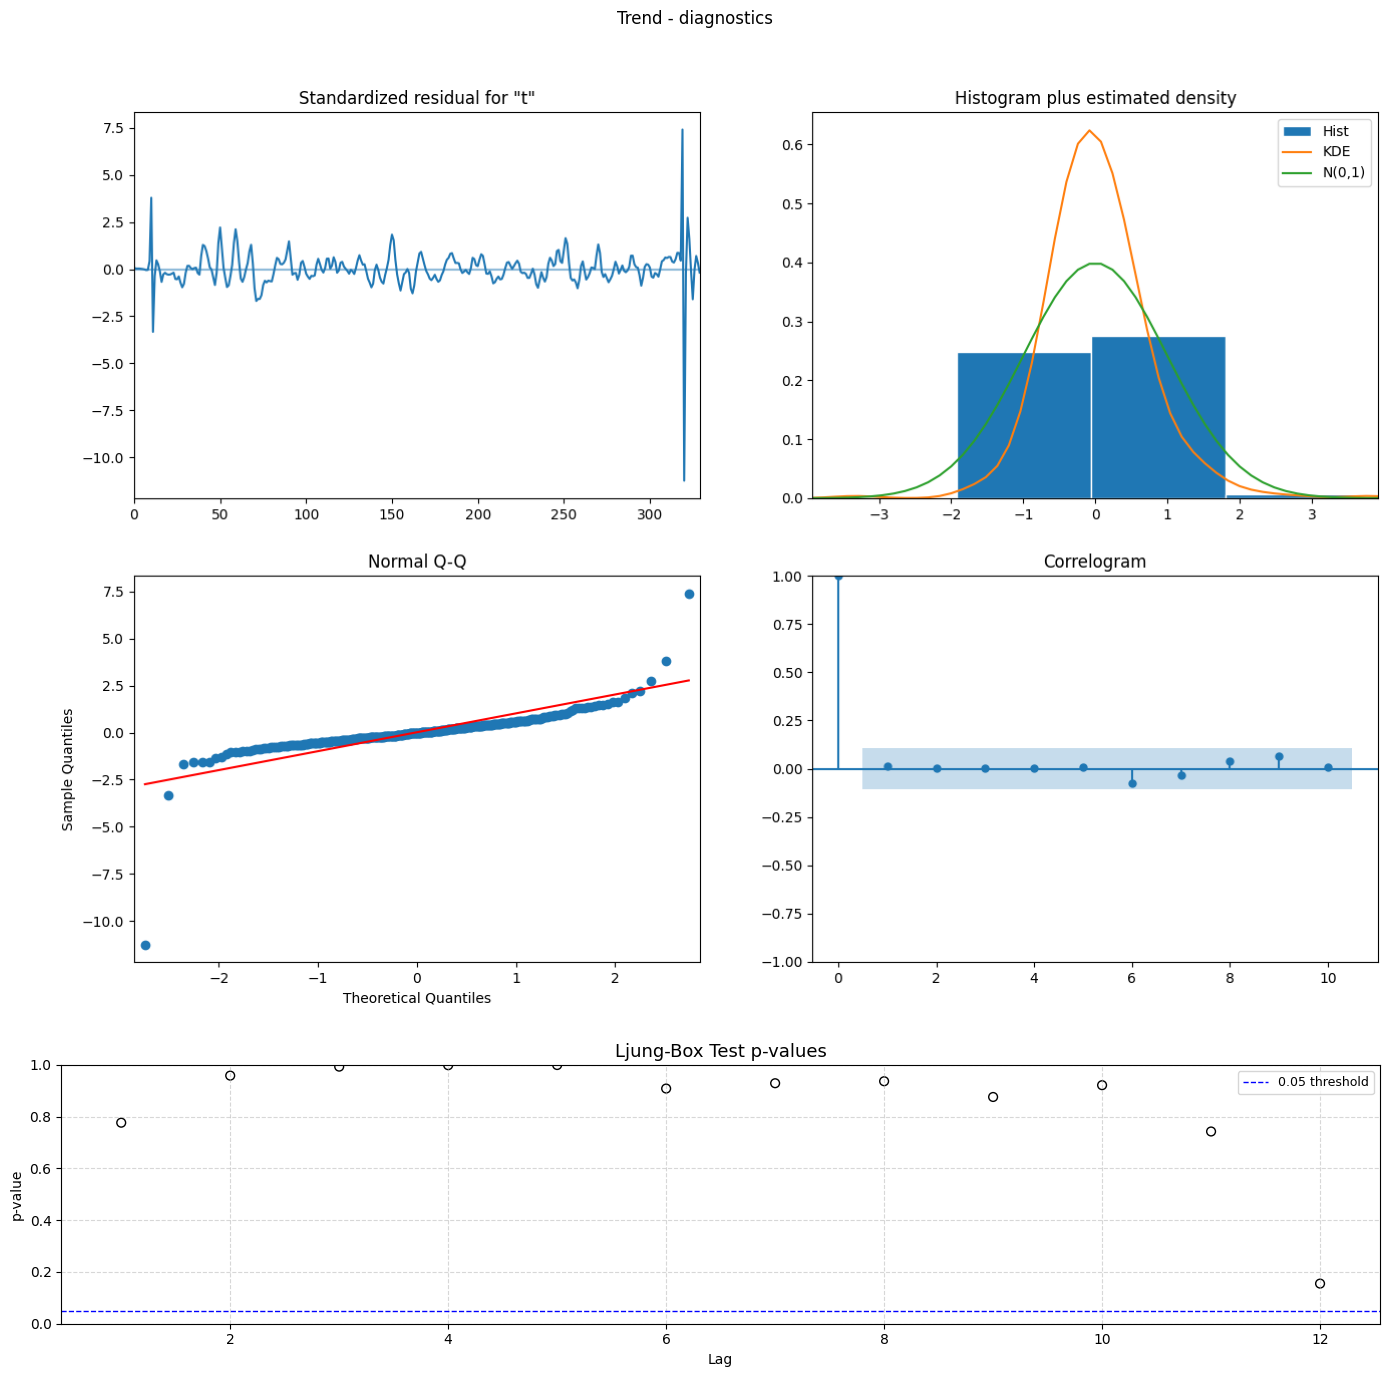

C:\Users\Dennis\AppData\Local\Temp\ipykernel_29112\3971803122.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


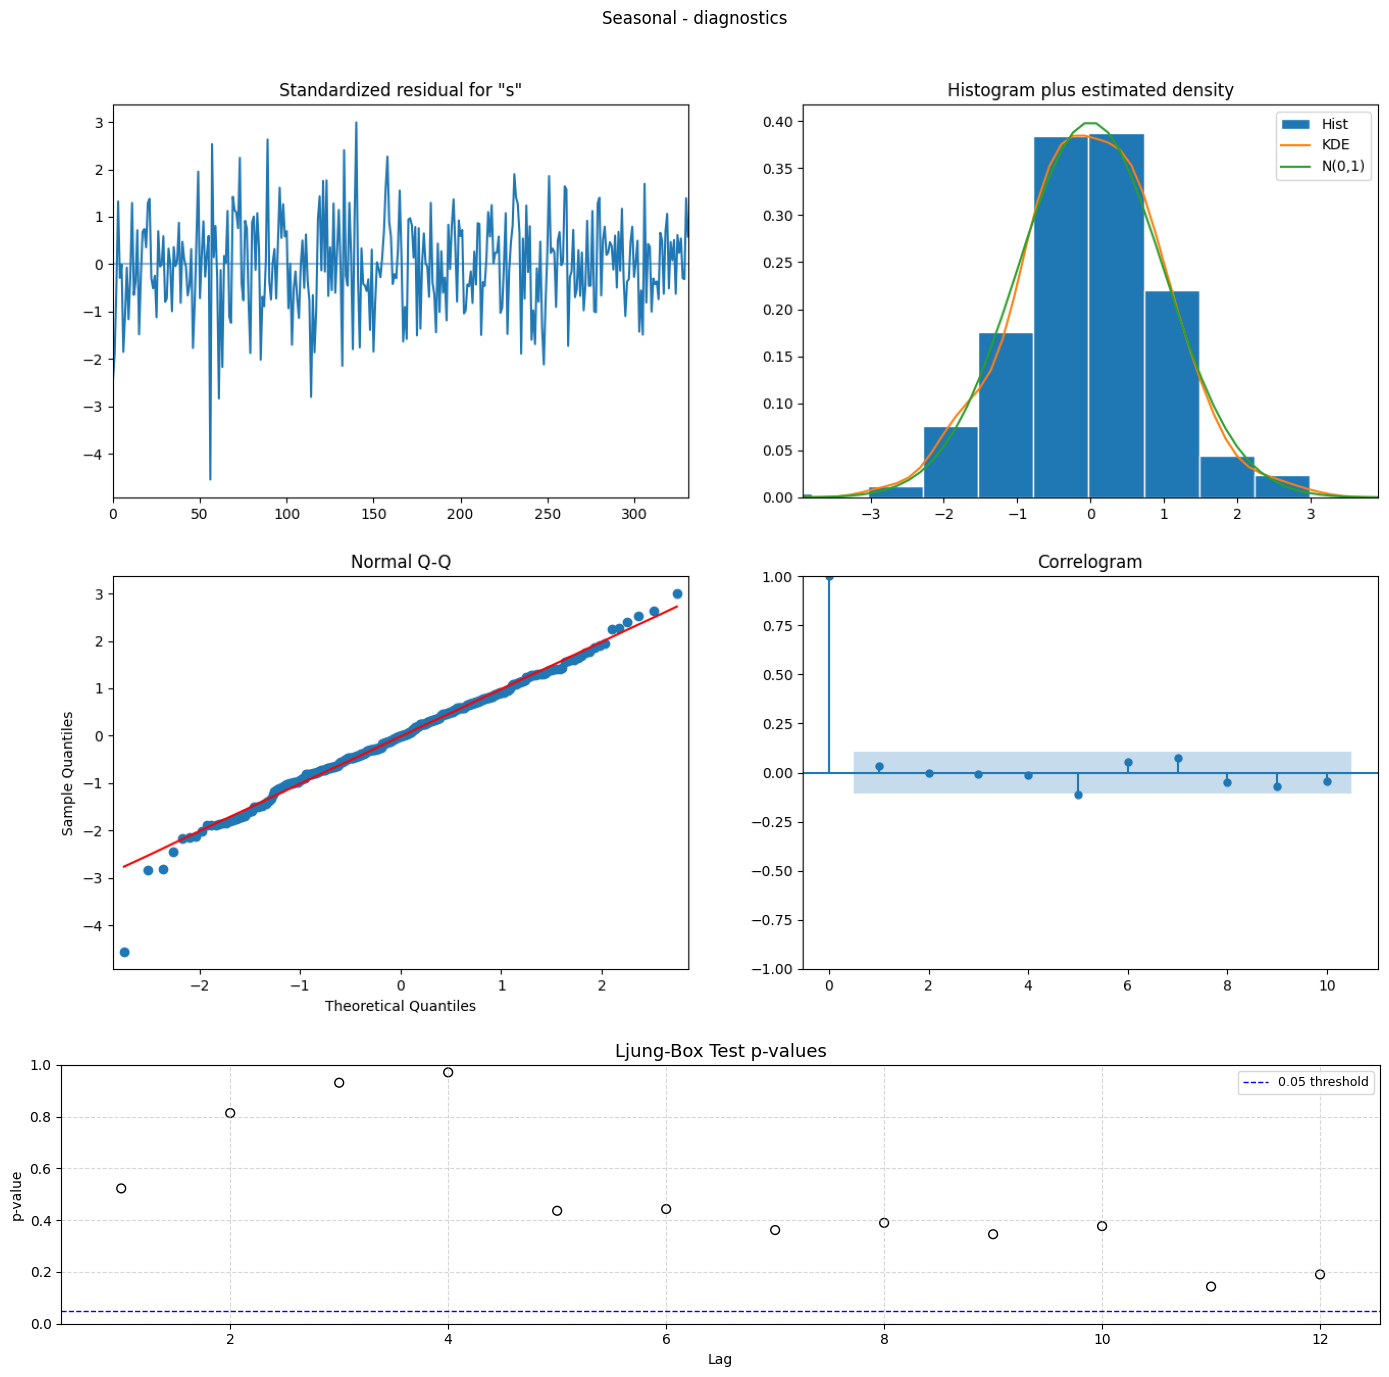

C:\Users\Dennis\AppData\Local\Temp\ipykernel_29112\3971803122.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


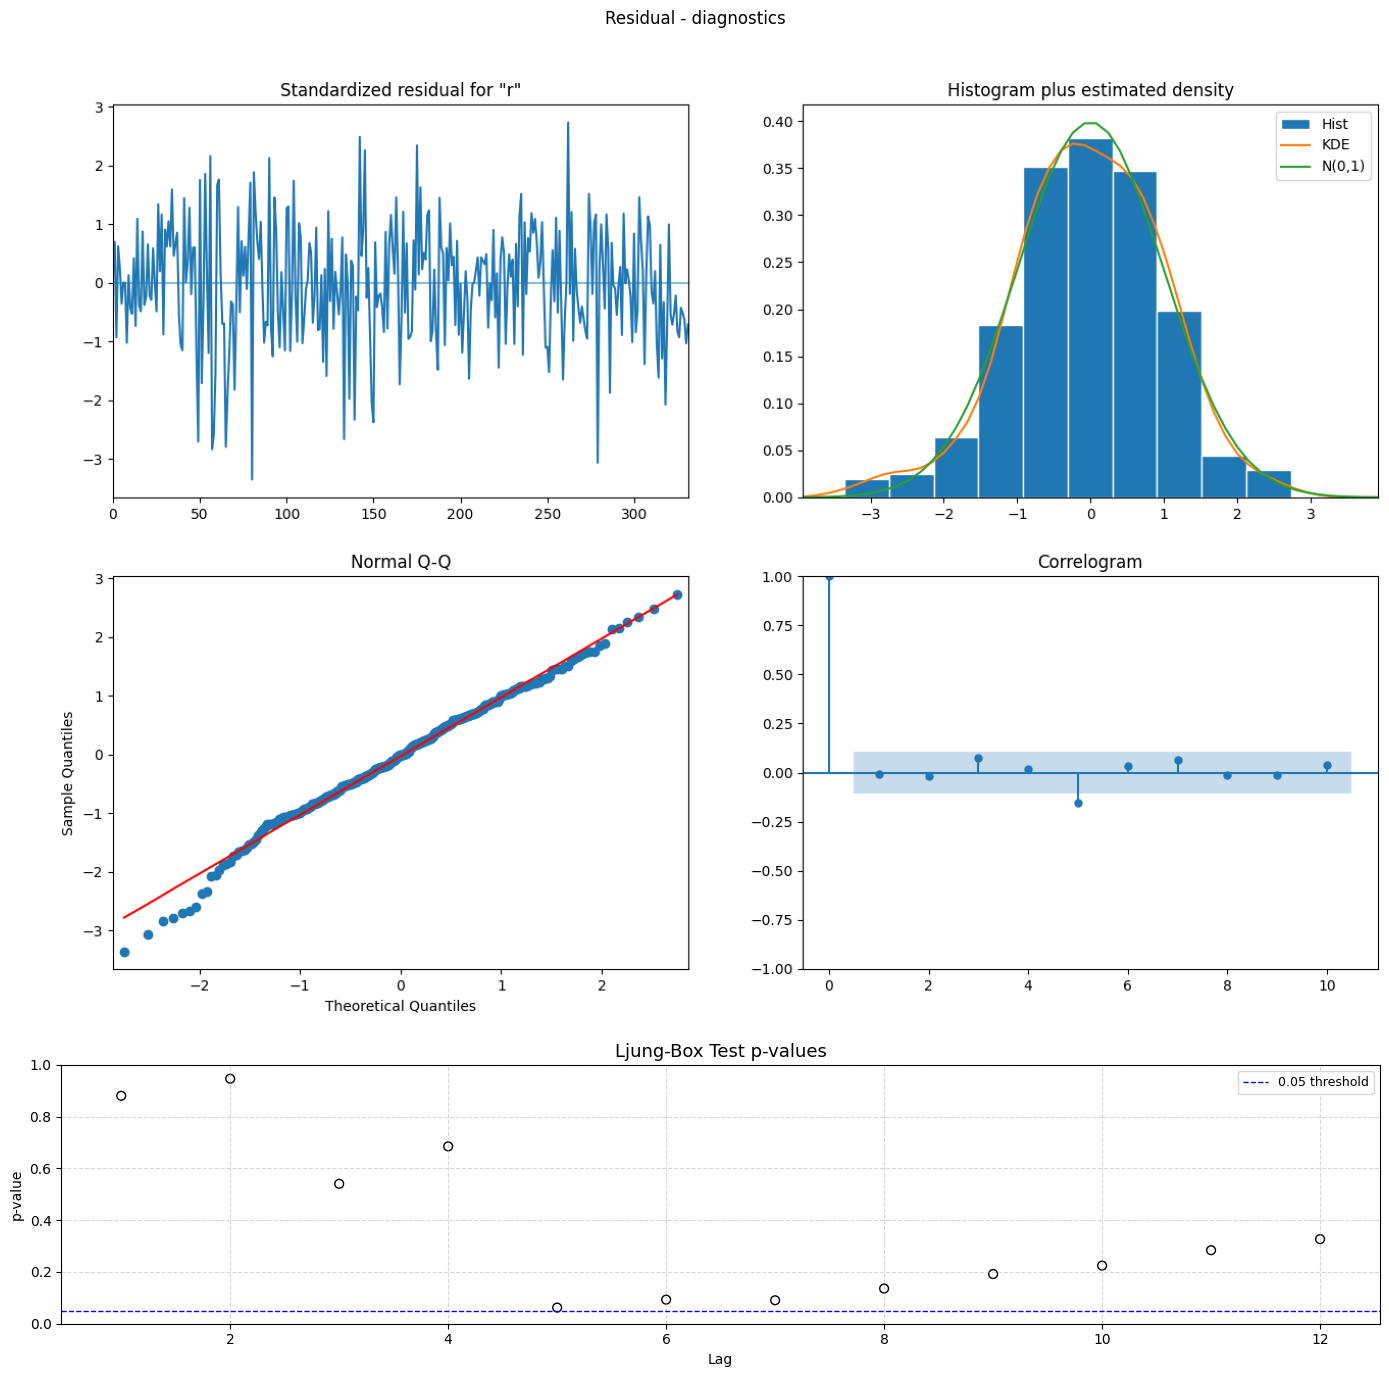

In [99]:
plot_clean_combined_diagnostics(trend_model, "Trend")
plot_clean_combined_diagnostics(seasonal_model, "Seasonal")
plot_clean_combined_diagnostics(resid_model, "Residual")

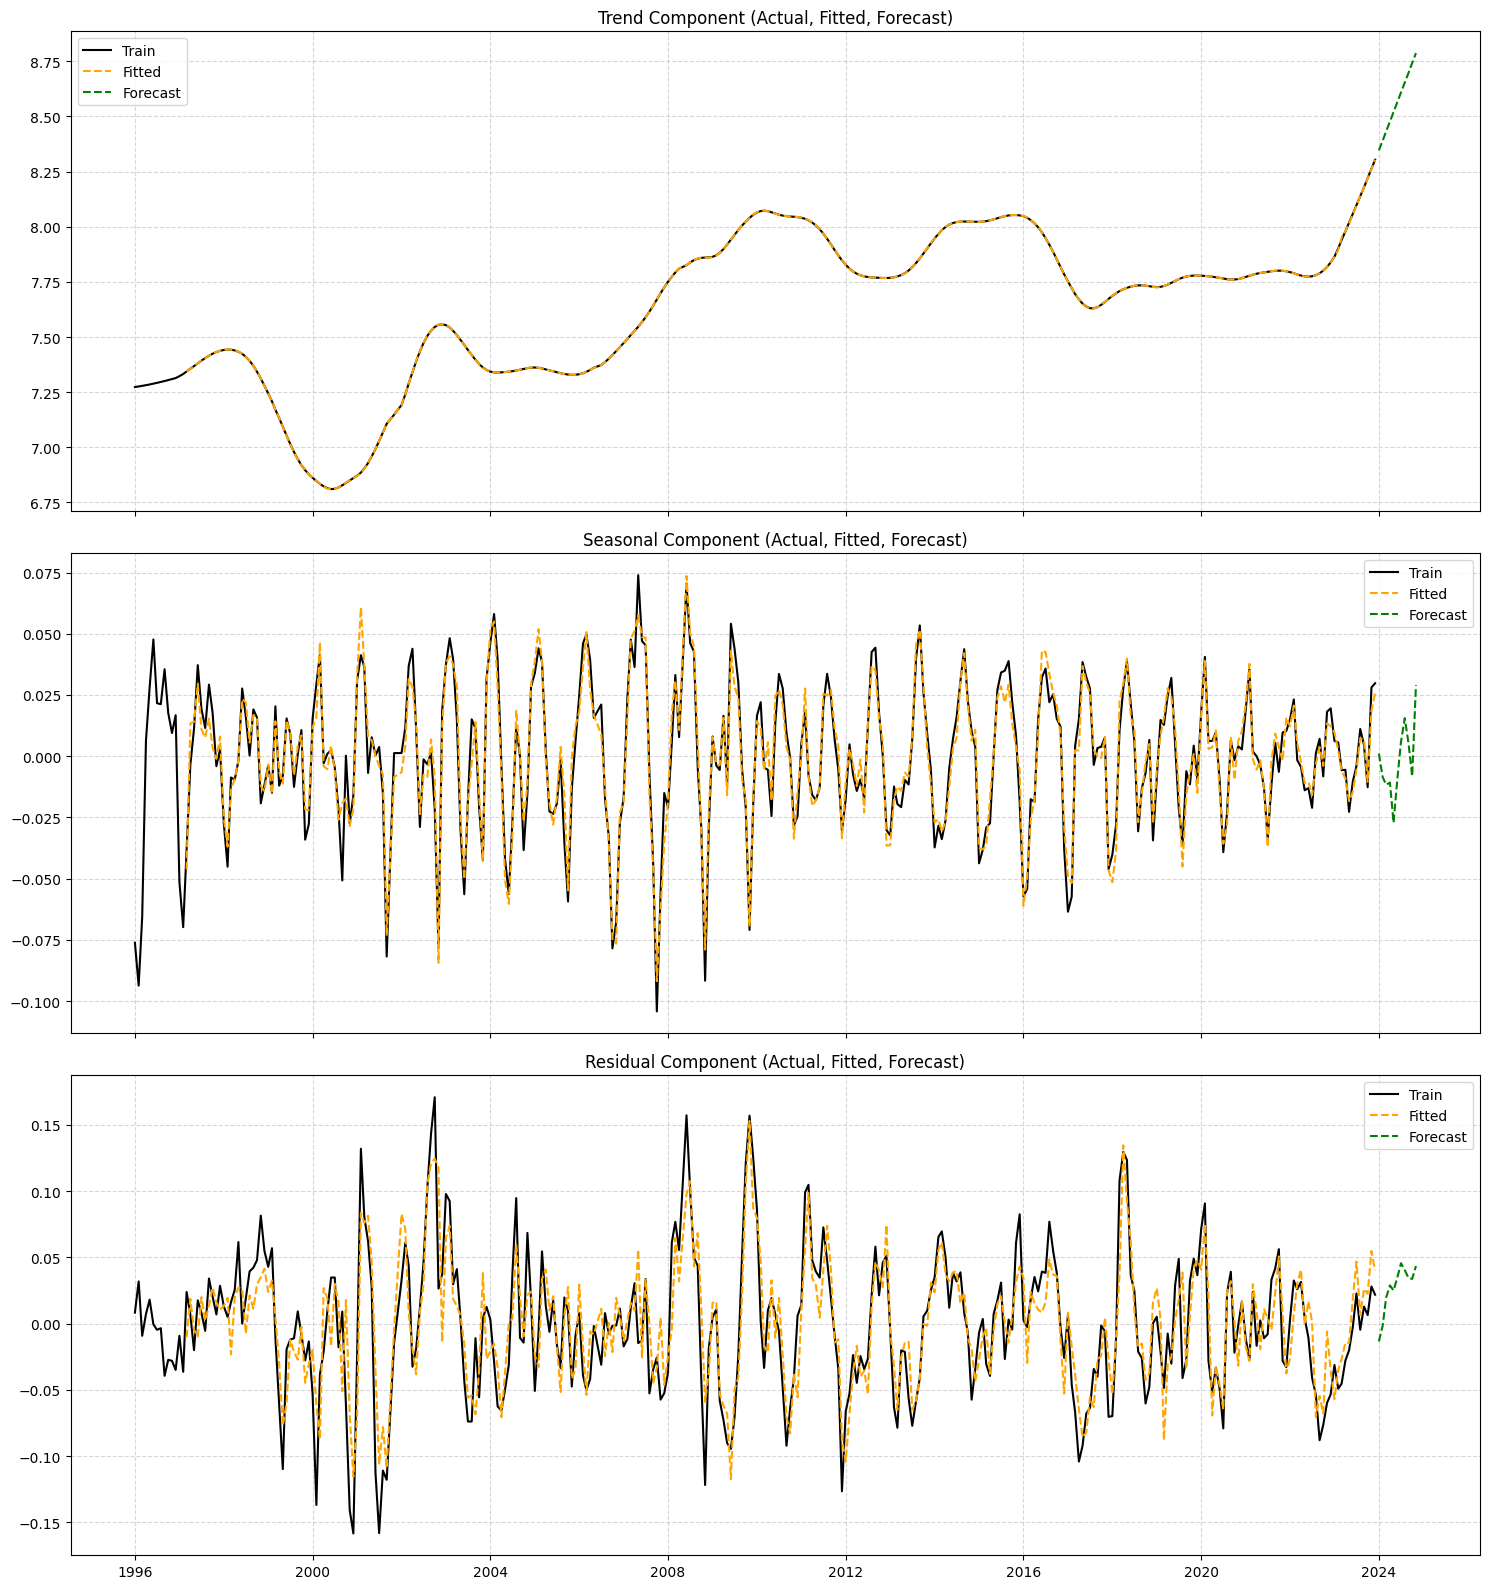

In [137]:
dates_test = test_df["YearMonth"]
actual_price_test = test_df["Monthly_Price"]
train_yearmonth_burned = train_df["YearMonth"].iloc[burn_in:]

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

# ① Trend
axes[0].plot(train_df["YearMonth"], train_df["trend"], label="Train", color="black")
axes[0].plot(train_yearmonth_burned, trend_fitted_log, label="Fitted", color="orange", linestyle="--")
axes[0].plot(dates_test, test_df["trend_forecast"], label="Forecast", color="green", linestyle="--")
axes[0].set_title("Trend Component (Actual, Fitted, Forecast)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# ② Seasonal
axes[1].plot(train_df["YearMonth"], train_df["seasonal"], label="Train", color="black")
axes[1].plot(train_yearmonth_burned, seasonal_fitted_log, label="Fitted", color="orange", linestyle="--")
axes[1].plot(dates_test, test_df["seasonal_forecast"], label="Forecast", color="green", linestyle="--")
axes[1].set_title("Seasonal Component (Actual, Fitted, Forecast)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# ③ Residual
axes[2].plot(train_df["YearMonth"], train_df["resid"], label="Train", color="black")
axes[2].plot(train_yearmonth_burned, resid_fitted_log, label="Fitted", color="orange", linestyle="--")
axes[2].plot(dates_test, test_df["resid_forecast"], label="Forecast", color="green", linestyle="--")
axes[2].set_title("Residual Component (Actual, Fitted, Forecast)")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()

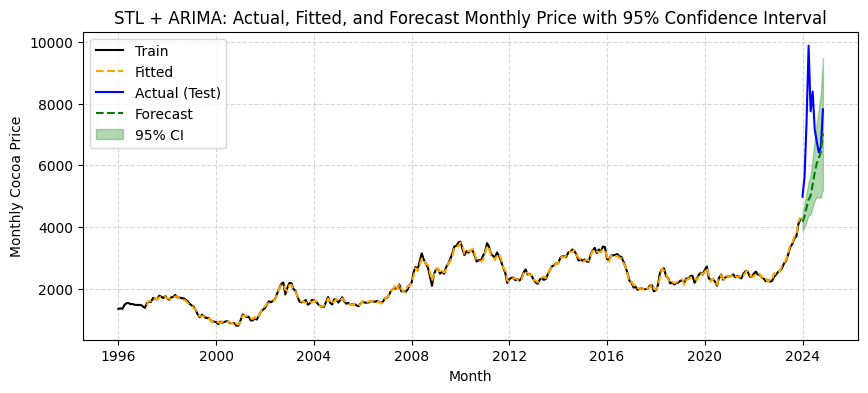

In [140]:
plt.figure(figsize=(10, 4))
# ④ Final Forecast with 95% CI
plt.plot(train_df["YearMonth"], train_df["Monthly_Price"], label="Train", color="black")
plt.plot(train_yearmonth_burned, fitted_price, label="Fitted", color="orange", linestyle="--")
plt.plot(dates_test, actual_price_test, label="Actual (Test)", color="blue", linestyle="solid")
plt.plot(dates_test, test_df["forecast"], label="Forecast", color="green", linestyle="--")

# Add confidence interval
plt.fill_between(
    dates_test,
    test_df["forecast_lower"],
    test_df["forecast_upper"],
    color="green",
    alpha=0.3,
    label="95% CI"
)

plt.title("STL + ARIMA: Actual, Fitted, and Forecast Monthly Price with 95% Confidence Interval")
plt.xlabel("Month")
plt.ylabel("Monthly Cocoa Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)


In [101]:
# Prepare inputs
y_true = test_df["Monthly_Price"]
y_pred = test_df["forecast"]
ci_df = test_df[["forecast_lower", "forecast_upper"]]

# Evaluate
evaluate_fitted(
    y_true=actual_price_train,
    y_fitted=fitted_price,
    model_name="Decomposed + ARIMA (Train)"
)

evaluate_forecast(y_true=y_true, y_pred=y_pred, ci_df=ci_df, model_name="STL + ARIMA Forecast")




🧪 Training Fit Metrics for Decomposed + ARIMA (Train):
R²   : 0.9942
RMSE: 52.7588
MAE : 41.6501
MAPE: 1.99%

📊 Forecast Performance Metrics for STL + ARIMA Forecast:
RMSE: 2225.0891
MAE : 1710.3778
MAPE: 22.12%
95% Prediction Interval Coverage: 36.36%


===========================================
LSTM
===========================================

Using device: cpu
X_train shape: (302, 30, 4)
X_test shape: (11, 30, 4)
y_train shape: (302,)
y_test shape: (11,)
Epoch 0, Loss: 0.2733
Epoch 10, Loss: 0.0374
Epoch 20, Loss: 0.0287
Epoch 30, Loss: 0.0264
Epoch 40, Loss: 0.0231
Epoch 50, Loss: 0.0204
Epoch 60, Loss: 0.0165
Epoch 70, Loss: 0.0158
Epoch 80, Loss: 0.0152
Epoch 90, Loss: 0.0150
Epoch 100, Loss: 0.0141
Epoch 110, Loss: 0.0136
Epoch 120, Loss: 0.0121
Epoch 130, Loss: 0.0096
Epoch 140, Loss: 0.0075
Epoch 150, Loss: 0.0051
Epoch 160, Loss: 0.0040
Epoch 170, Loss: 0.0030
Epoch 180, Loss: 0.0025
Epoch 190, Loss: 0.0022
Epoch 200, Loss: 0.0021
Epoch 210, Loss: 0.0019
Epoch 220, Loss: 0.0017
Epoch 230, Loss: 0.0017
Epoch 240, Loss: 0.0017
Epoch 250, Loss: 0.0016
Epoch 260, Loss: 0.0015
Epoch 270, Loss: 0.0014
Epoch 280, Loss: 0.0015
Early stopping at epoch 282, Best Loss: 0.0015


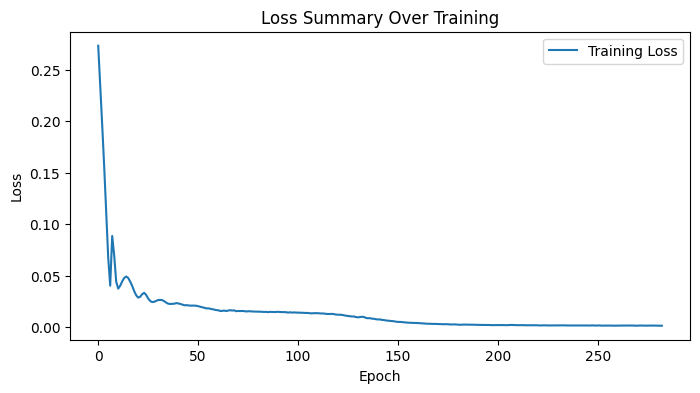

In [102]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Set seeds for reproducibility
SEED = 999
os.environ["PYTHONHASHSEED"] = str(SEED)  # For built-in hash randomization
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Force deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# For PyTorch 1.10+ (optional but recommended if available)
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print(f"Warning: {e}")

# Load dataset
df = pd.read_csv("cocoa_data.csv")  
predictor_columns = ["Monthly_MidRate", "Monthly_TAVG", "Monthly_PRCP", "Monthly_Production"]

# Convert date column to datetime
df["YearMonth"] = pd.to_datetime(df["YearMonth"])
df.set_index("YearMonth", inplace=True)
df["Year"] = df.index.year
df["Month"] = df.index.month

scaler_x = StandardScaler()
#scaler_y = StandardScaler()
scaler_y = MinMaxScaler()
#scaler_x.fit(df[predictor_columns])  
#scaler_y.fit(df[['Monthly_log_Price']])  

seq_length = 30
# Split dataset: Train (before 2024), Test (2024 only)
train_data = df[:-11]
test_data = df[-11-seq_length:]  # Modify as needed
train_data = train_data.copy()
test_data = test_data.copy()

# Normalize data 
train_data[predictor_columns] = scaler_x.fit_transform(train_data[predictor_columns])
train_data["Scaled_Price"] = scaler_y.fit_transform(train_data[["Monthly_log_Price"]])
test_data[predictor_columns] = scaler_x.transform(test_data[predictor_columns])
test_data["Scaled_Price"] = scaler_y.transform(test_data[["Monthly_log_Price"]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[predictor_columns].iloc[i : i + seq_length].values)  # Use predictor columns
        y.append(data.iloc[i + seq_length - 1]["Scaled_Price"])  # Target is 'Scaled_Price'
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape to match LSTM input format
X_train = X_train.reshape(X_train.shape[0], seq_length, len(predictor_columns))
X_test = X_test.reshape(X_test.shape[0], seq_length, len(predictor_columns))

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training data to GPU
X_train_torch = X_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
X_test_torch = X_test_torch.to(device)

# Print shapes
print("X_train shape:", X_train.shape)  # (num_samples, seq_length, num_features)
print("X_test shape:", X_test.shape)    # (num_samples, seq_length, num_features)
print("y_train shape:", y_train.shape)  # (num_samples, 1)
print("y_test shape:", y_test.shape)    # (num_samples, 1)

# Define LSTM Model. This includes a MC Dropout that used for approximating the CI.
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=4, dropout=0.015, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Explicit dropout layer for MC Dropout
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])  # Apply dropout at inference for MC Dropout
        out = self.fc(out)
        return out

    def predict_with_mc_dropout(self, x, n_forward_passes=50):
        """
        Perform multiple stochastic forward passes with MC Dropout to estimate uncertainty.
        """
        self.train()  # Enable dropout during inference for Monte Carlo sampling
        torch.manual_seed(SEED)
        predictions = torch.stack([self(x) for _ in range(n_forward_passes)], dim=0)
        return predictions.mean(dim=0), predictions.std(dim=0)  # Return mean and std for uncertainty

# Initialize Model
# Move model to GPU
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

# Training Loop with Early Stopping
num_epochs = 800
patience = 30
min_delta = 1e-4

train_losses = []
best_loss = float("inf")
epochs_no_improve = 0

torch.cuda.empty_cache()
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Early Stopping
    if loss.item() < best_loss - min_delta:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        torch.cuda.empty_cache()

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}, Best Loss: {best_loss:.4f}")
        break
# After training
torch.save(model.state_dict(), "best_model.pth")

# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Summary Over Training")
plt.legend()
plt.show()


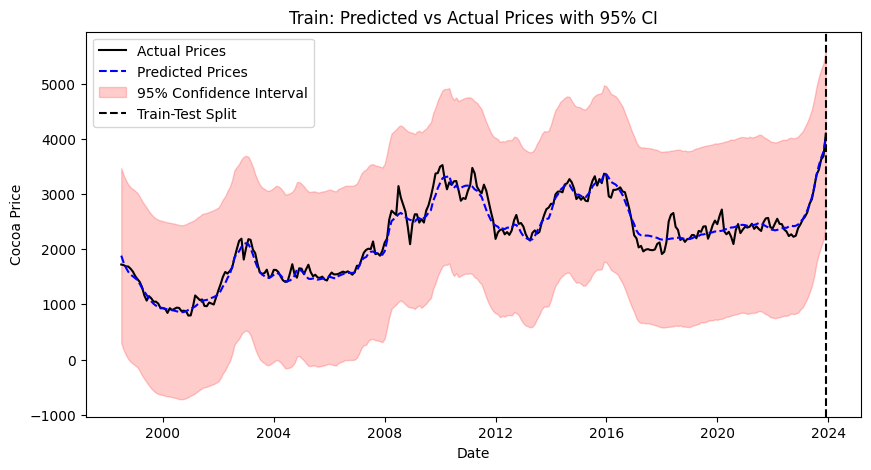

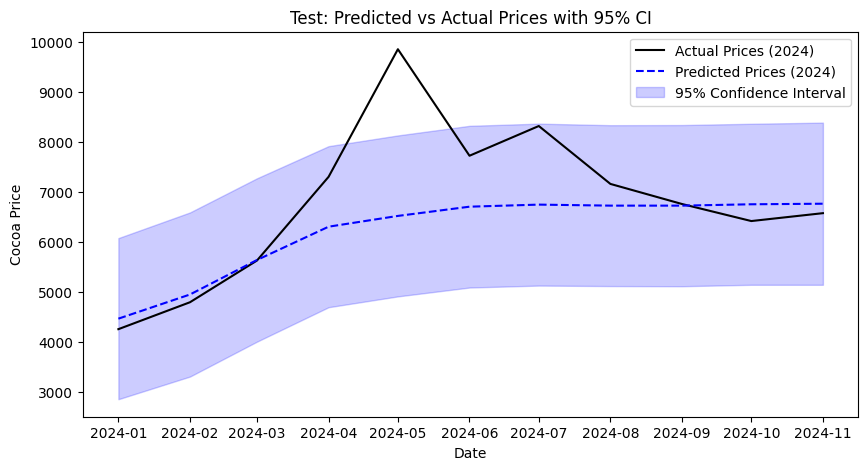

R² Score (Train): 0.9599
MAPE (Test): 9.33%
RMSE (Test): 1207.8214
95% Confidence Interval Coverage: 90.91%


In [ ]:
# Ensure model is in evaluation mode
model.eval()
# Number of MC Dropout simulations
n_simulations = 100

# Get mean and uncertainty estimates for train/test data
with torch.no_grad():
    y_train_pred_mean, y_train_pred_std = model.predict_with_mc_dropout(X_train_torch, n_simulations)
    y_test_pred_mean, y_test_pred_std = model.predict_with_mc_dropout(X_test_torch, n_simulations)

y_train_pred_mean = y_train_pred_mean.cpu().detach().numpy()
y_train_pred_std = y_train_pred_std.cpu().detach().numpy()
y_test_pred_mean = y_test_pred_mean.cpu().detach().numpy()
y_test_pred_std = y_test_pred_std.cpu().detach().numpy()

# Reverse transform predictions
y_train_pred_actual = np.expm1(scaler_y.inverse_transform(y_train_pred_mean)).flatten()
y_test_pred_actual = np.expm1(scaler_y.inverse_transform(y_test_pred_mean)).flatten()
y_train_actual = np.expm1(scaler_y.inverse_transform(y_train.reshape(-1, 1)))
y_test_actual = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1, 1)))
y_train_pred_std_actual = np.expm1(scaler_y.inverse_transform(y_train_pred_std.reshape(-1, 1))).flatten()
y_test_pred_std_actual = np.expm1(scaler_y.inverse_transform(y_test_pred_std.reshape(-1, 1))).flatten()

# Plot Predicted vs Actual Prices (Entire Dataset)
plt.figure(figsize=(10, 5))
plt.plot(train_data.index[seq_length:], y_train_actual, label="Actual Prices", color="black")
plt.plot(train_data.index[seq_length:], y_train_pred_actual, label="Predicted Prices", color="blue", linestyle="dashed")

plt.fill_between(train_data.index[seq_length:], 
                 y_train_pred_actual - 1.96 * y_train_pred_std_actual,
                 y_train_pred_actual + 1.96 * y_train_pred_std_actual, 
                 color="red", alpha=0.2, label="95% Confidence Interval")
plt.axvline(train_data.index[-1], linestyle="--", color="black", label="Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Cocoa Price")
plt.title("Train: Predicted vs Actual Prices with 95% CI")
plt.legend()
plt.savefig("train_predicted_vs_actual_4vars.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()

# Plot Test vs. Predicted Prices with Confidence Interval
plt.figure(figsize=(10, 5))
plt.plot(test_data.index[seq_length:], y_test_actual, label="Actual Prices (2024)", color="black")
plt.plot(test_data.index[seq_length:], y_test_pred_actual, label="Predicted Prices (2024)", color="blue", linestyle="dashed")
plt.fill_between(test_data.index[seq_length:], 
                 y_test_pred_actual - 1.96 * y_test_pred_std_actual,
                 y_test_pred_actual + 1.96 * y_test_pred_std_actual, 
                 color="blue", alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Cocoa Price")
plt.title("Test: Predicted vs Actual Prices with 95% CI")
plt.legend()
plt.savefig("test_predicted_vs_actual_4vars.png", dpi=300, bbox_inches="tight")
plt.show()

# PERFORMANCE METRICS
r2_train = r2_score(y_train_actual, y_train_pred_actual)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual) * 100
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

print(f"R² Score (Train): {r2_train:.4f}")
print(f"MAPE (Test): {mape_test:.2f}%")
print(f"RMSE (Test): {rmse_test:.4f}")

In [131]:
# Compute metrics for TRAIN set
r2_train = r2_score(y_train_actual, y_train_pred_actual)
mae_train = mean_absolute_error(y_train_actual, y_train_pred_actual)
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred_actual) * 100
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))

# Compute metrics for TEST set
r2_test = r2_score(y_test_actual, y_test_pred_actual)
mae_test = mean_absolute_error(y_test_actual, y_test_pred_actual)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual) * 100
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

# Print results
print(f"TRAIN METRICS:")
print(f"  R² Score    : {r2_train:.4f}")
print(f"  MAE         : {mae_train:.4f}")
print(f"  MAPE        : {mape_train:.2f}%")
print(f"  RMSE        : {rmse_train:.4f}")

print("\nTEST METRICS:")
print(f"  R² Score    : {r2_test:.4f}")
print(f"  MAE         : {mae_test:.4f}")
print(f"  MAPE        : {mape_test:.2f}%")
print(f"  RMSE        : {rmse_test:.4f}")

# Compute 95% confidence intervals
lower_bound = y_test_pred_actual - 1.96 * y_test_pred_std_actual
upper_bound = y_test_pred_actual + 1.96 * y_test_pred_std_actual
y_test_flat = y_test_actual.flatten()
# Check if actual test values fall within the CI
covered_points = ((y_test_flat >= lower_bound) & (y_test_flat <= upper_bound)).sum()
total_points = len(y_test_actual)
# Compute 95% CI coverage percentage
ci_coverage = (covered_points / total_points) * 100
print(f"95% Confidence Interval Coverage: {ci_coverage:.2f}%")

TRAIN METRICS:
  R² Score    : 0.9599
  MAE         : 102.8866
  MAPE        : 4.75%
  RMSE        : 138.9132

TEST METRICS:
  R² Score    : 0.3575
  MAE         : 754.0692
  MAPE        : 9.33%
  RMSE        : 1207.8214
95% Confidence Interval Coverage: 90.91%


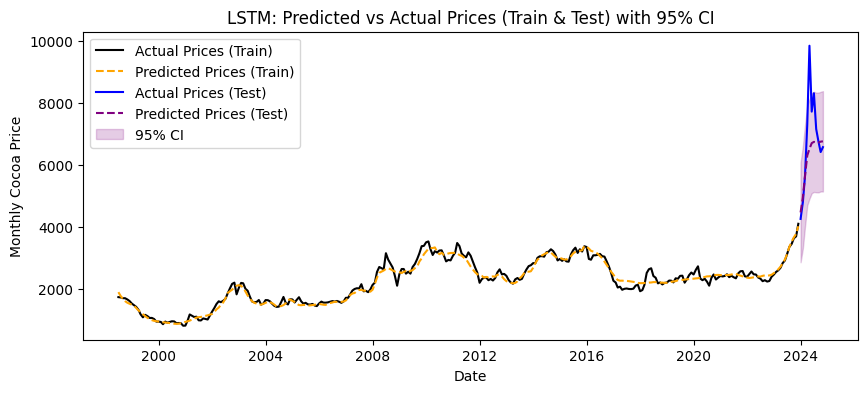

In [141]:
plt.figure(figsize=(10, 4))

# Train Data Plot
# plt.plot(df.index, df["Monthly_Price"], label="Monthly Price (Dataset)", color="green", linestyle="dotted")
plt.plot(train_data.index[seq_length:], y_train_actual, label="Actual Prices (Train)", color="black")
plt.plot(train_data.index[seq_length:], y_train_pred_actual, label="Predicted Prices (Train)", color="orange", linestyle="dashed")
# plt.fill_between(train_data.index[seq_length:], 
#                  y_train_pred_actual - 1.96 * y_train_pred_std_actual,
#                  y_train_pred_actual + 1.96 * y_train_pred_std_actual, 
#                  color="blue", alpha=0.2)

# Test Data Plot
plt.plot(test_data.index[seq_length:], y_test_actual, label="Actual Prices (Test)", color="blue", linestyle="solid")
plt.plot(test_data.index[seq_length:], y_test_pred_actual, label="Predicted Prices (Test)", color="purple", linestyle="dashed")
plt.fill_between(test_data.index[seq_length:], 
                 y_test_pred_actual - 1.96 * y_test_pred_std_actual,
                 y_test_pred_actual + 1.96 * y_test_pred_std_actual, 
                 color="purple", alpha=0.2, label="95% CI")

# Add a vertical line to indicate the train-test split
# plt.axvline(train_data.index[-1], linestyle="--", color="black", label="Train-Test Split")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Monthly Cocoa Price")
plt.title("LSTM: Predicted vs Actual Prices (Train & Test) with 95% CI")
plt.legend()

# Save and show the plot
plt.savefig("combined_train_test_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

# axes[3].plot(train_df["YearMonth"], train_df["Monthly_Price"], label="Train", color="black")
# axes[3].plot(train_yearmonth_burned, fitted_price, label="Fitted", color="orange", linestyle="--")
# axes[3].plot(dates_test, actual_price_test, label="Actual (Test)", color="blue", linestyle="--")


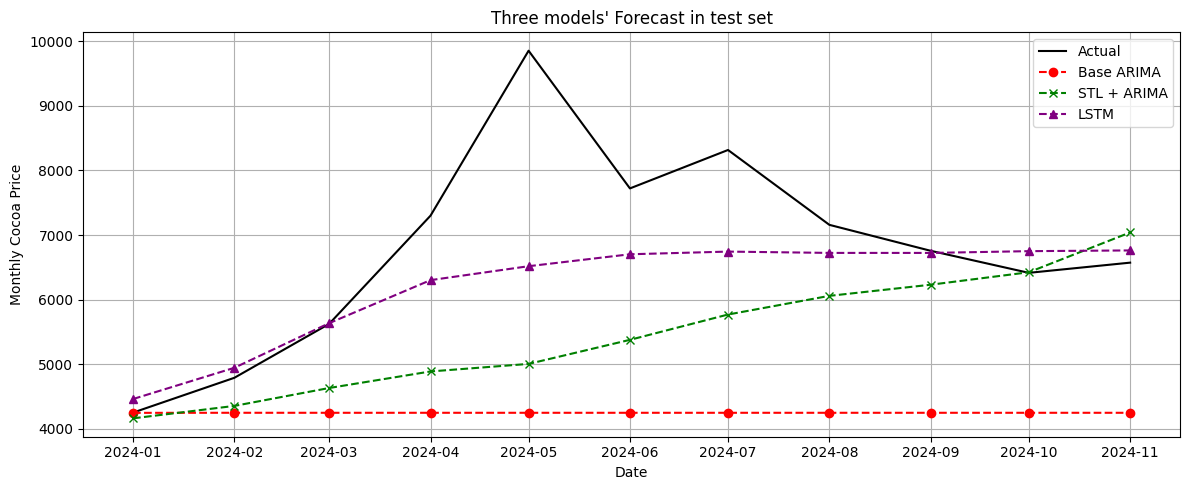

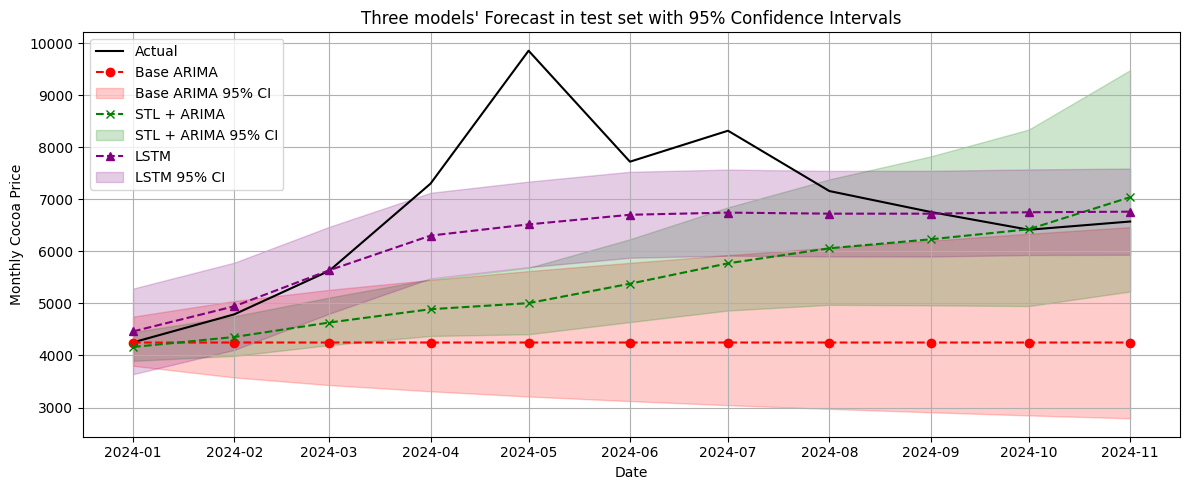

In [135]:
# Convert the zoom range
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-11-01")

# Build time axis for test set (LSTM version seems to use last 11 months)
test_index = pd.date_range(start="2024-01-01", periods=11, freq="MS")

# First plot: Actual + Forecasts (no CI)
plt.figure(figsize=(12, 5))
plt.plot(test_index, y_test_actual, label="Actual", color="black")
plt.plot(test_index, base_sarima_forecast_mean, label="Base ARIMA", linestyle="--", marker='o', color="red")
plt.plot(test_index, forecast_price, label="STL + ARIMA", linestyle="--", marker='x', color="green")
plt.plot(test_index, y_test_pred_actual, label="LSTM", linestyle="--", marker='^', color="purple")
plt.title("Three models' Forecast in test set")
plt.xlabel("Date")
plt.ylabel("Monthly Cocoa Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Second plot: Add 95% Confidence Intervals
plt.figure(figsize=(12, 5))
plt.plot(test_index, y_test_actual, label="Actual", color="black")
plt.plot(test_index, base_sarima_forecast_mean, label="Base ARIMA", linestyle="--", marker='o', color="red")
plt.fill_between(test_index,
                 base_sarima_forecast_ci['lower Monthly_log_Price'],
                 base_sarima_forecast_ci['upper Monthly_log_Price'],
                 color='red', alpha=0.2, label="Base ARIMA 95% CI")

plt.plot(test_index, forecast_price, label="STL + ARIMA", linestyle="--", marker='x', color="green")
plt.fill_between(test_index,
                 forecast_lower,
                 forecast_upper,
                 color='green', alpha=0.2, label="STL + ARIMA 95% CI")

plt.plot(test_index, y_test_pred_actual, label="LSTM", linestyle="--", marker='^', color="purple")
plt.fill_between(test_index,
                 y_test_pred_actual - y_test_pred_std_actual,
                 y_test_pred_actual + y_test_pred_std_actual,
                 color='purple', alpha=0.2, label="LSTM 95% CI")

plt.title("Three models' Forecast in test set with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Monthly Cocoa Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
